In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

main = pd.read_json('../results_cleaned/mdf_all.json')
main = main.dropna(how='any',axis=0) 
main.info()
mdf = main.iloc[:,2:-1]
mdf
# mdf.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 0 to 118
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tree_idx      111 non-null    int64  
 1   test_number   111 non-null    object 
 2   leaf_temp     111 non-null    float64
 3   Ta            111 non-null    float64
 4   cwsi          111 non-null    float64
 5   NDVI median   111 non-null    float64
 6   GNDVI median  111 non-null    float64
 7   OSAVI median  111 non-null    float64
 8   LCI median    111 non-null    float64
 9   NDRE median   111 non-null    float64
 10  SWP           111 non-null    float64
 11  SWPc          111 non-null    object 
dtypes: float64(9), int64(1), object(2)
memory usage: 11.3+ KB


,leaf_temp,Ta,cwsi,NDVI median,GNDVI median,OSAVI median,LCI median,NDRE median,SWP
0,31.000000,35.41,0.225049,0.680596,0.564822,0.343672,0.238299,0.165678,21.33
1,31.500000,35.41,0.254403,0.709513,0.589902,0.347813,0.241712,0.165408,16.33
2,30.833333,35.41,0.215264,0.696943,0.578733,0.352290,0.224013,0.152534,24.00
3,30.666667,35.41,0.205479,0.713962,0.580458,0.358707,0.222680,0.149966,17.17
4,30.000000,35.41,0.166341,0.692211,0.576588,0.331614,0.233609,0.160824,18.50
...,...,...,...,...,...,...,...,...,...
114,31.066667,36.07,0.228963,0.671807,0.567401,0.286633,0.226394,0.156473,19.83
115,32.700000,36.07,0.324853,0.678749,0.569933,0.291628,0.220869,0.152646,25.17
116,32.100000,36.07,0.289628,0.648854,0.533746,0.297958,0.182921,0.125482,19.50
117,33.733333,36.07,0.385519,0.575638,0.489463,0.223720,0.153978,0.109748,18.00


In [148]:
corrs = mdf.corr()
print(corrs['SWP'].sort_values(ascending=False),'\n')

SWP             1.000000
Ta              0.551078
leaf_temp       0.430160
cwsi            0.430160
NDRE median     0.177583
LCI median      0.149763
GNDVI median    0.082618
NDVI median     0.054667
OSAVI median    0.011253
Name: SWP, dtype: float64 



<AxesSubplot:>

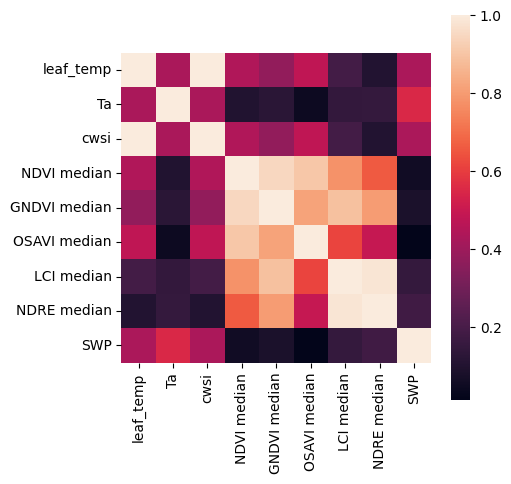

In [149]:
f , ax = plt.subplots(figsize=(5,5))

sns.heatmap(abs(corrs),square=True,vmax=1)

<AxesSubplot:>

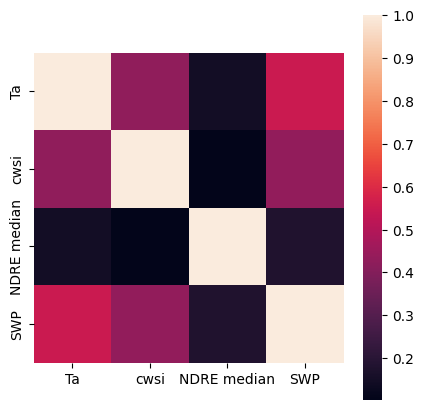

In [150]:
mdf = mdf.drop(['LCI median','NDVI median','GNDVI median', 'leaf_temp','OSAVI median'], axis=1)
# mdf = mdf.drop(['leaf_temp'], axis=1)
corrs = mdf.corr()
f , ax = plt.subplots(figsize=(5,5))
sns.heatmap(abs(corrs),square=True,vmax=1)

In [151]:
main['SWPc'].unique()

array(['WL-2', 'WL-1', 'WL-3'], dtype=object)

In [152]:
correct_label= np.array(['WL-1', 'WL-2', 'WL-3'], dtype=object)
correct_label


array(['WL-1', 'WL-2', 'WL-3'], dtype=object)

In [153]:
label_quality = LabelEncoder()
main['SWPc'] = label_quality.fit_transform(main['SWPc'])
main['SWPc'].isnull().sum()

0

In [154]:
bins = (2,18,40)
group_names = ['WL1','WL2']
main['SWPc2'] = pd.cut(main['SWP'], bins=bins , labels=group_names)
main['SWPc2'] = label_quality.fit_transform(main['SWPc2'])
main['SWPc2'].isnull().sum()

0

In [155]:
main

,tree_idx,test_number,leaf_temp,Ta,cwsi,NDVI median,GNDVI median,OSAVI median,LCI median,NDRE median,SWP,SWPc,SWPc2
0,1,T1,31.000000,35.41,0.225049,0.680596,0.564822,0.343672,0.238299,0.165678,21.33,1,1
1,2,T1,31.500000,35.41,0.254403,0.709513,0.589902,0.347813,0.241712,0.165408,16.33,0,0
2,3,T1,30.833333,35.41,0.215264,0.696943,0.578733,0.352290,0.224013,0.152534,24.00,2,1
3,4,T1,30.666667,35.41,0.205479,0.713962,0.580458,0.358707,0.222680,0.149966,17.17,0,0
4,5,T1,30.000000,35.41,0.166341,0.692211,0.576588,0.331614,0.233609,0.160824,18.50,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,13,T7,31.066667,36.07,0.228963,0.671807,0.567401,0.286633,0.226394,0.156473,19.83,1,1
115,14,T7,32.700000,36.07,0.324853,0.678749,0.569933,0.291628,0.220869,0.152646,25.17,2,1
116,15,T7,32.100000,36.07,0.289628,0.648854,0.533746,0.297958,0.182921,0.125482,19.50,1,1
117,16,T7,33.733333,36.07,0.385519,0.575638,0.489463,0.223720,0.153978,0.109748,18.00,0,0


SWPc 
 1    38
2    38
0    35
Name: SWPc, dtype: int64


<AxesSubplot:xlabel='SWPc', ylabel='count'>

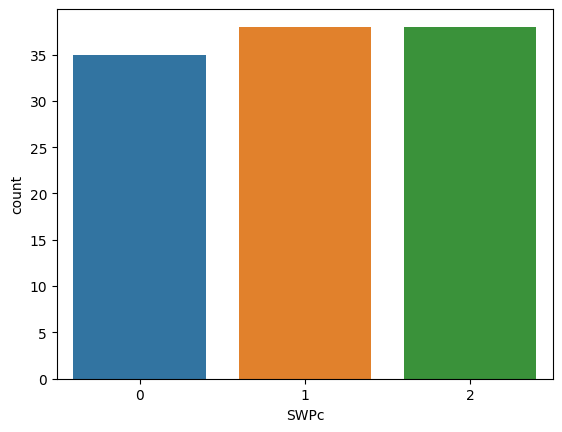

In [156]:
print('SWPc \n',main['SWPc'].value_counts())
sns.countplot(x=main['SWPc'])


 SWPc2 
 1    82
0    29
Name: SWPc2, dtype: int64


<AxesSubplot:xlabel='SWPc2', ylabel='count'>

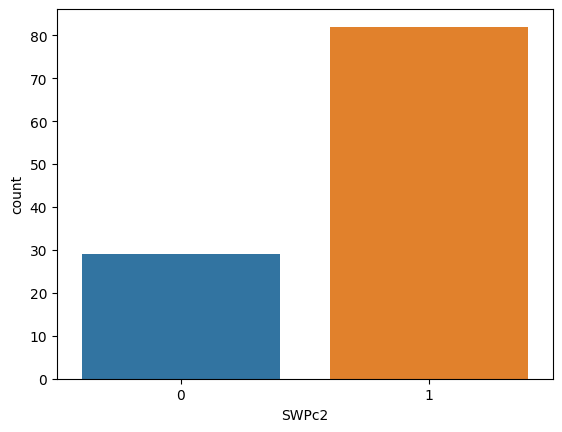

In [157]:
print('\n SWPc2 \n',main['SWPc2'].value_counts())
sns.countplot(x=main['SWPc2'])

In [158]:
X = mdf.drop('SWP',axis=1)
y = main['SWPc2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, \
                                                    random_state = 10)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
cv=10

In [159]:
rfc = RandomForestClassifier(n_estimators=250)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)
print('Random Forest accuracy: ',accuracy_score(y_test, pred_rfc))
print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

Random Forest accuracy:  0.6764705882352942
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.68      1.00      0.81        23

    accuracy                           0.68        34
   macro avg       0.34      0.50      0.40        34
weighted avg       0.46      0.68      0.55        34

[[ 0 11]
 [ 0 23]]


c:\Users\Students\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Students\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Students\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [160]:
clf=SVC()
clf.fit(X_train,y_train)
pred_clf = clf.predict(X_test)
print('SVM accuracy: ',accuracy_score(y_test, pred_clf))
print(classification_report(y_test, pred_clf))
print(confusion_matrix(y_test, pred_clf))

SVM accuracy:  0.6764705882352942
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.68      1.00      0.81        23

    accuracy                           0.68        34
   macro avg       0.34      0.50      0.40        34
weighted avg       0.46      0.68      0.55        34

[[ 0 11]
 [ 0 23]]


c:\Users\Students\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Students\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Students\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [161]:
gnb= GaussianNB()
gnb.fit(X_train,y_train)
pred_gnb = gnb.predict(X_test)
print('DT accuracy: ',accuracy_score(y_test, pred_gnb))
print(classification_report(y_test, pred_gnb))
print(confusion_matrix(y_test, pred_gnb))

DT accuracy:  0.5882352941176471
              precision    recall  f1-score   support

           0       0.40      0.55      0.46        11
           1       0.74      0.61      0.67        23

    accuracy                           0.59        34
   macro avg       0.57      0.58      0.56        34
weighted avg       0.63      0.59      0.60        34

[[ 6  5]
 [ 9 14]]


In [162]:
dt= tree.DecisionTreeClassifier()
dt.fit(X_train,y_train)
pred_dt = dt.predict(X_test)
print('DT accuracy: ',accuracy_score(y_test, pred_dt))
print(classification_report(y_test, pred_dt))
print(confusion_matrix(y_test, pred_dt))

DT accuracy:  0.6470588235294118
              precision    recall  f1-score   support

           0       0.33      0.09      0.14        11
           1       0.68      0.91      0.78        23

    accuracy                           0.65        34
   macro avg       0.51      0.50      0.46        34
weighted avg       0.57      0.65      0.57        34

[[ 1 10]
 [ 2 21]]


In [163]:
knn= KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
print('KNN accuracy: ',accuracy_score(y_test, pred_knn))
print(classification_report(y_test, pred_knn))
print(confusion_matrix(y_test, pred_knn))

KNN accuracy:  0.7058823529411765
              precision    recall  f1-score   support

           0       0.67      0.18      0.29        11
           1       0.71      0.96      0.81        23

    accuracy                           0.71        34
   macro avg       0.69      0.57      0.55        34
weighted avg       0.70      0.71      0.64        34

[[ 2  9]
 [ 1 22]]


In [164]:
mlpc= MLPClassifier(hidden_layer_sizes=(15,15),max_iter=2000)
mlpc.fit(X_train,y_train)
pred_mlpc = mlpc.predict(X_test)
print('Neural Network accuracy: ',accuracy_score(y_test, pred_mlpc))
print(classification_report(y_test, pred_mlpc))
print(confusion_matrix(y_test, pred_mlpc))

Neural Network accuracy:  0.7058823529411765
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.70      1.00      0.82        23

    accuracy                           0.71        34
   macro avg       0.85      0.55      0.49        34
weighted avg       0.80      0.71      0.61        34

[[ 1 10]
 [ 0 23]]


In [165]:
cval_rf = np.array(cross_val_score(rfc, X, y, cv=cv))
cval_svc = np.array(cross_val_score(clf, X, y, cv=cv))
cval_gnb = np.array(cross_val_score(gnb, X, y, cv=cv))
cval_dt = np.array(cross_val_score(dt, X, y, cv=cv))
cval_knn = np.array(cross_val_score(knn, X, y, cv=cv))
cval_nn = np.array(cross_val_score(mlpc, X, y, cv=cv))

In [170]:

print('                  mean             std    ')
print('\n RandomF   ',cval_rf.mean(),cval_rf.std())
print('\n SVM       ',cval_svc.mean(),cval_svc.std())
print('\n GaussianNB',cval_gnb.mean(),cval_gnb.std())
print('\n DT        ',cval_dt.mean(),cval_dt.std())
print('\n KNN       ',cval_knn.mean(),cval_knn.std())
print('\n NN        ',cval_nn.mean(),cval_nn.std())

                  mean             std    

 RandomF    0.8295454545454545 0.11644262234044997

 SVM        0.7386363636363636 0.02736726040634613

 GaussianNB 0.6075757575757577 0.2629955639676584

 DT         0.8030303030303031 0.1422952349318048

 KNN        0.7840909090909092 0.19530914253312565

 NN         0.7386363636363636 0.02736726040634613


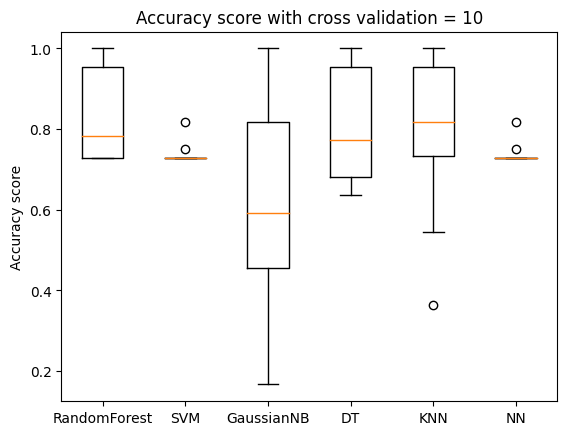

In [167]:
data = [cval_rf,cval_svc,cval_gnb,cval_dt,cval_knn,cval_nn]
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6],['RandomForest','SVM','GaussianNB','DT','KNN','NN'])
plt.ylabel('Accuracy score')
plt.title('Accuracy score with cross validation = ' + str(cv))
plt.show()

Optimized Hyperparameters
